In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import OrdinalEncoder,  OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import itertools
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Step 0- Loading and inspecting data

In [2]:
url= "https://raw.githubusercontent.com/nithinpradeep38/datasets/main/Train.csv"
data= pd.read_csv(url)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
data.shape

(8523, 12)

We have 12 variables. 11 independent variables and 1 dependent variable (Item Outlet sales).

In [4]:
for col in data.columns:
    print(f"{col}: {data[col].dtype}")

Item_Identifier: object
Item_Weight: float64
Item_Fat_Content: object
Item_Visibility: float64
Item_Type: object
Item_MRP: float64
Outlet_Identifier: object
Outlet_Establishment_Year: int64
Outlet_Size: object
Outlet_Location_Type: object
Outlet_Type: object
Item_Outlet_Sales: float64


We have 11 independent variables out of which 4 are numerical columns and 7 are categorical columns. The output variable is a numerical column which makes this a **regression problem.**

In [5]:
#Let us separate the categorial columns.
cat_col= [col for col in data.columns if data[col].dtype== 'object']
cat_col

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [6]:
num_col= [col for col in data.columns if data[col].dtype!= 'object']
num_col

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [7]:
num_col.remove('Item_Outlet_Sales')
num_col

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [8]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We see 1463 values missing in Item_weight column and 2410 values missing in Outlet_size column.

#### Unique values for the categorical columns

In [9]:
for col in cat_col:
    print(f"{col}: {data[col].nunique()}")

Item_Identifier: 1559
Item_Fat_Content: 5
Item_Type: 16
Outlet_Identifier: 10
Outlet_Size: 3
Outlet_Location_Type: 3
Outlet_Type: 4


## Step 1- Checking distributions

### Item Weight

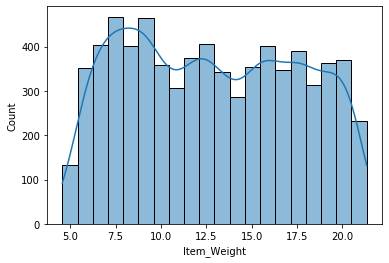

12.86

In [10]:
sns.histplot(data['Item_Weight'], kde= True, bins= 20)
plt.show()
np.round(data['Item_Weight'].mean(),2)

The mean weight of items is 12.86 and the weights range between 5 to 20 kgs.

### Item visibility

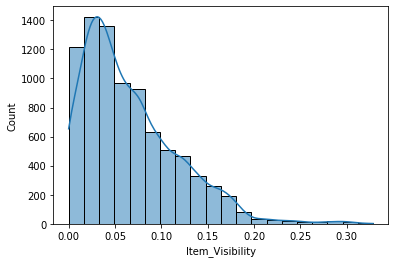

In [11]:
sns.histplot(data['Item_Visibility'], kde= True, bins= 20)
plt.show()

Most items have low visibility followed by outliers with high visibility. It is a positively skewed distribution.

### Item MRP

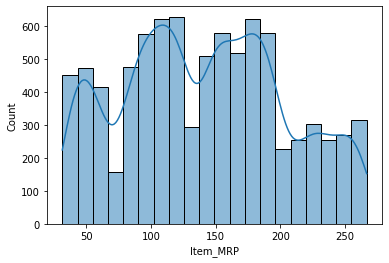

Range of MRP is (31.29, 266.8884)


In [12]:
sns.histplot(data['Item_MRP'], kde= True, bins= 20)
plt.show()
print(f"Range of MRP is ({data['Item_MRP'].min()}, {data['Item_MRP'].max()})")

Prices are clustered at around 50, 100 and 175

### Outlet establishment year


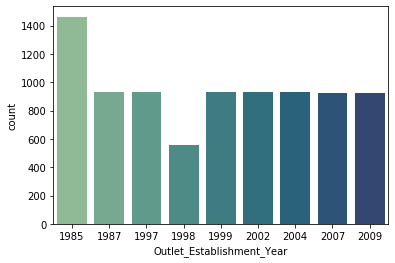

In [13]:
sns.countplot(x= 'Outlet_Establishment_Year',data= data, palette= 'crest')
plt.show()

The most number of outlets were opened up in 1985 (~1400). In 1998 there was a big dip. The rest of the years had same or similar number of outlets established.

### Item fat content

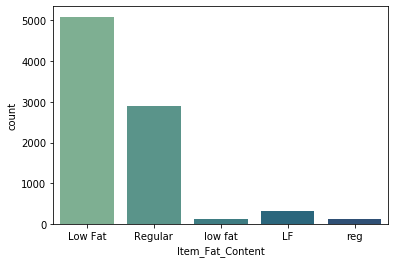

In [14]:
sns.countplot(x='Item_Fat_Content', data= data , palette='crest')
plt.show()

Majority of the data points have either **Low fat** or **Regular** as the Item_fat_content. 

**low fat** and **LF** may just be **Low fat**. To reduce cardinality, we can map these to Low fat category.
Similarly, **reg** can be renamed as **Regular**.

### Item Type

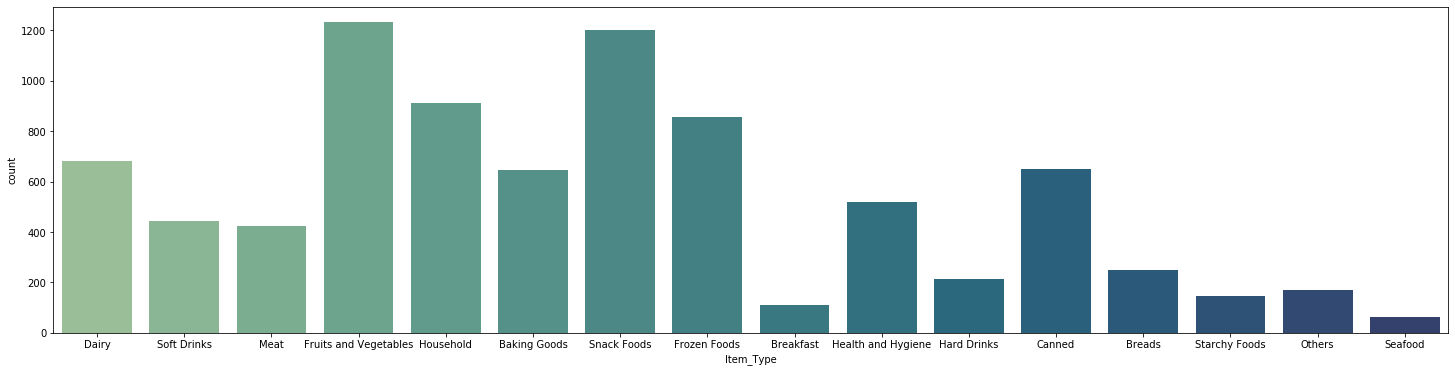

In [15]:
plt.figure(figsize= (25,6))
sns.countplot(x='Item_Type', data= data , palette='crest')
plt.show()

There are 16 levels for this variable and some of them like breakfast and seafood appear to be rare variables. This high cardinality can be an issue, especially in tree based algorithms. Rare labels in training set can cause overfitting. If such labels are only present in test set, the algorithm may not know what do with them. So we may have to group these labels.

### Outlet size

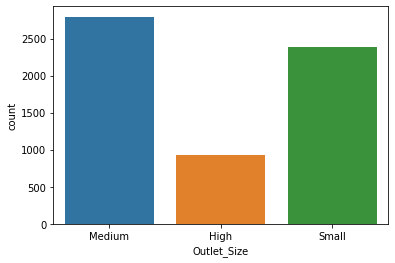

In [16]:
sns.countplot(x='Outlet_Size', data=data)
plt.show()

### Outlet Location type

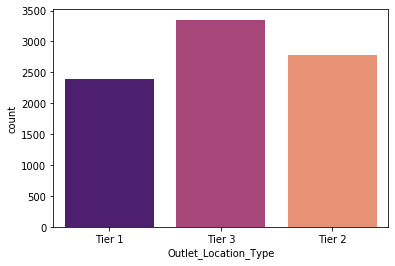

In [17]:
sns.countplot(x='Outlet_Location_Type', data=data, palette= 'magma')
plt.show()

### Outlet Type

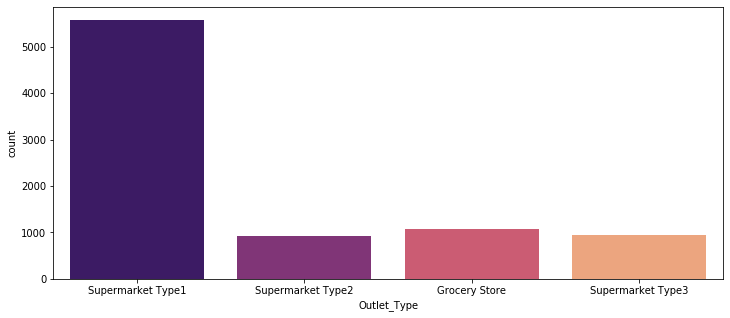

In [18]:
plt.figure(figsize= (12,5))
sns.countplot(x='Outlet_Type', data=data, palette= 'magma')
plt.show()

### Outlet Identifier

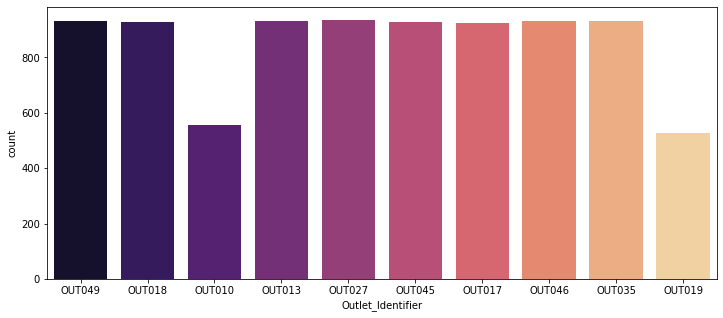

In [19]:
plt.figure(figsize= (12,5))
sns.countplot(x='Outlet_Identifier', data=data, palette= 'magma')
plt.show()

## Step2- Data Processing- Reducing cardinality


Next, we need to plot the variables against the target variable. But before that, we need to treat variables with high cardinality.

The item_identifier column has 1559 unique values. Such high cardinality is undesirable. So we will try to transform this column to have a lower cardinality. Let us first inspect this.


There are

#### Treating high cardinality and fixing duplicate labels

#### 1. Item Identifier and Item Fat Content

In [20]:
data['Item_Identifier'].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

The first two digits maybe indicative of a sub-category. Let us inspect the same.

In [21]:
first_two= set(data['Item_Identifier'].str[:2])
first_two

{'DR', 'FD', 'NC'}

The first two digits of item identifier are either of DR, FD or NC. Let us inspect the sub-set of data individually for these.

In [22]:
data[data['Item_Identifier'].str[:2]=='DR']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
27,DRJ59,11.650,low fat,0.019356,Hard Drinks,39.1164,OUT013,1987,High,Tier 3,Supermarket Type1,308.9312
34,DRH01,17.500,Low Fat,0.097904,Soft Drinks,174.8738,OUT046,1997,Small,Tier 1,Supermarket Type1,2085.2856
37,DRZ11,8.850,Regular,0.113124,Soft Drinks,122.5388,OUT018,2009,Medium,Tier 3,Supermarket Type2,1609.9044
...,...,...,...,...,...,...,...,...,...,...,...,...
8484,DRJ49,6.865,Low Fat,0.000000,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8506,DRF37,17.250,Low Fat,0.084676,Soft Drinks,263.1910,OUT018,2009,Medium,Tier 3,Supermarket Type2,3944.8650


In [23]:
data[data['Item_Identifier'].str[:2]=='FD']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
...,...,...,...,...,...,...,...,...,...,...,...,...
8515,FDH24,20.700,Low Fat,0.021518,Baking Goods,157.5288,OUT018,2009,Medium,Tier 3,Supermarket Type2,1571.2880
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850


In [24]:
data[data['Item_Identifier'].str[:2]=='NC']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
16,NCB42,11.80,Low Fat,0.008596,Health and Hygiene,115.3492,OUT018,2009,Medium,Tier 3,Supermarket Type2,1621.8888
22,NCB30,14.60,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
25,NCD06,13.00,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
31,NCS17,18.60,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009,Medium,Tier 3,Supermarket Type2,2741.7644
...,...,...,...,...,...,...,...,...,...,...,...,...
8500,NCQ42,20.35,Low Fat,0.000000,Household,125.1678,OUT017,2007,NaN,Tier 2,Supermarket Type1,1907.5170
8502,NCH43,8.42,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8504,NCN18,NaN,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8516,NCJ19,18.60,Low Fat,0.118661,Others,58.7588,OUT018,2009,Medium,Tier 3,Supermarket Type2,858.8820


It is clear from the sub-sets of data that 'DR' represents items that are 'drinks', 'FD' represents items that are 'food' and 'NC' represents items that are 'non consumables'.

So as a data pre-processing step, we can map this column to represent these three categories thereby reducing cardinality of this column.

In [25]:
data['Item_Identifier']= data['Item_Identifier'].apply(lambda x:x[0:2]).map({'FD': "Food", 'DR': 'Drinks', 'NC': 'Non Consumable'})
data['Item_Fat_Content']= data['Item_Fat_Content'].map({'Low Fat': 'Low Fat', 'Regular': 'Regular', 'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

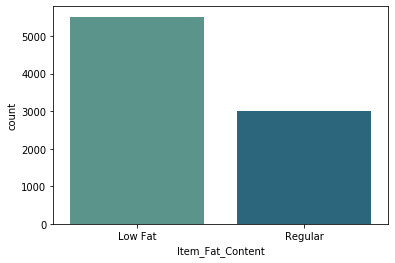

In [26]:
sns.countplot(x='Item_Fat_Content', data= data , palette='crest')
plt.show()


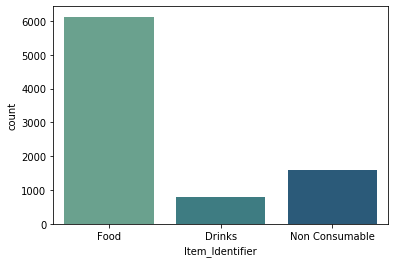

In [27]:
sns.countplot(x='Item_Identifier', data= data , palette='crest')
plt.show()

In [28]:
data[data['Item_Identifier']=='Non Consumable']['Item_Fat_Content'].unique()

array(['Low Fat'], dtype=object)

It looks like the non consumables all have item fat content as Low fat. But it makes little sense to map the fat content of non consumables. Hence, this maybe labelled incorrectly as fat content of a non consumable cannot really influence the sales of that product. Let us map it to a new category named 'Not Applicable'.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


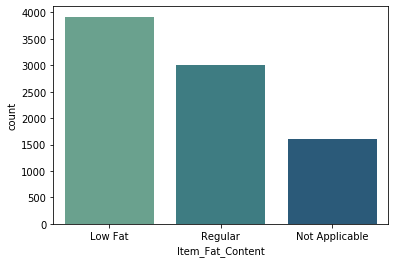

In [29]:
data['Item_Fat_Content'].loc[data['Item_Identifier']== 'Non Consumable']= 'Not Applicable'
sns.countplot(x='Item_Fat_Content', data= data , palette='crest')
plt.show()


#### 2. Item Type
We have solved the cardinality issues in Item_Fat_Content and Item_Identifier columns. Now let us look at item type.

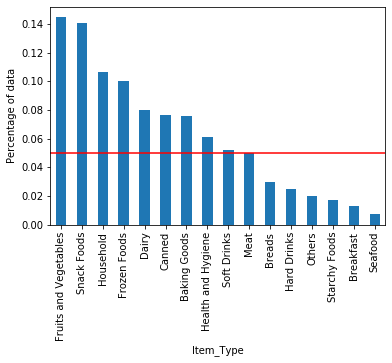

In [30]:
def rare_label_plot(data, col):
    temp_df = pd.Series(data[col].value_counts() / len(data))

    # Make plot with these percentages.
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # Add a line at 5 % to flag the threshold for rare categories.
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of data')
    plt.show()
    
rare_label_plot(data, 'Item_Type')

Let us plot the mean of target variable across the different rare labels.

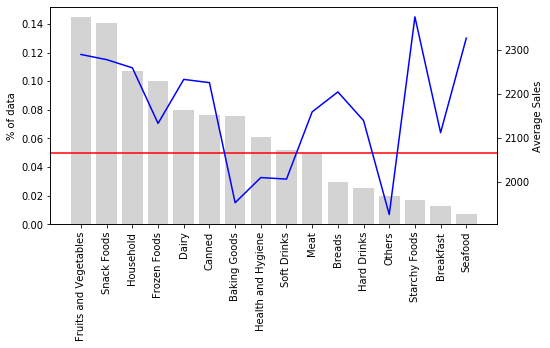

In [31]:
def plot_mean(data, col):
    l= len(data)

    temp_df= pd.Series(data[col].value_counts()/l).reset_index()
    temp_df.columns= [col, '% of data']
    temp_df= temp_df.merge(data.groupby([col])['Item_Outlet_Sales'].mean().reset_index(), on=col, how= 'left')


    fig, ax= plt.subplots(figsize= (8,4))
    plt.xticks(temp_df.index, temp_df[col], rotation= 90)
    ax2= ax.twinx()
    ax.bar(temp_df.index, temp_df['% of data'], color= 'lightgrey')
    ax2.plot(temp_df.index, temp_df['Item_Outlet_Sales'],color= 'blue')
    ax.axhline(y=0.05, color= 'red')
    ax.set_ylabel('% of data')
    ax2.set_ylabel('Average Sales')
    plt.show()
    
plot_mean(data, 'Item_Type')


For the labels that are in more than 5% of the dataset, we do see a negative trend of sales price. So these labels maybe meaningful.

There is a lot of variance across the rare labels. Let us plot the box plots for these variables.

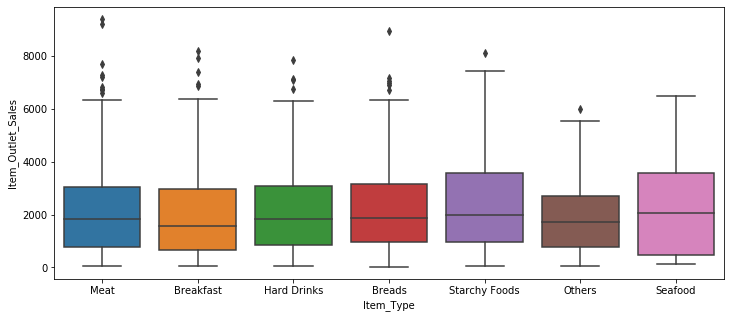

In [32]:
temp_df= pd.Series(data['Item_Type'].value_counts()/len(data)).reset_index()
temp_df.columns= ['Item_Type', '% of data']
rare_labels= list(temp_df[temp_df['% of data']< 0.05]['Item_Type'])

plt.figure(figsize= (12,5))
sns.boxplot(x= 'Item_Type', y= 'Item_Outlet_Sales', data= data[data['Item_Type'].isin(rare_labels)])


In [33]:
rare_labels

['Meat',
 'Breads',
 'Hard Drinks',
 'Others',
 'Starchy Foods',
 'Breakfast',
 'Seafood']

Let us see if there is any meaningful difference in distribution of these rare labels by doing one way F-test.

In [34]:
fvalue, pvalue = stats.f_oneway(data[data['Item_Type']== 'Meat']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Breads']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Hard Drinks']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Seafood']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Starchy Foods']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Breakfast']['Item_Outlet_Sales'],
                                data[data['Item_Type']== 'Others']['Item_Outlet_Sales']
                               )



pvalue

0.3573271647648517

We can combine the rare labels into one category and plot the mean again.

In [35]:
grouping_dict = {
        k: ('rare' if k in rare_labels else k)
        for k in data['Item_Type'].unique()
        
    }
grouping_dict

{'Dairy': 'Dairy',
 'Soft Drinks': 'Soft Drinks',
 'Meat': 'rare',
 'Fruits and Vegetables': 'Fruits and Vegetables',
 'Household': 'Household',
 'Baking Goods': 'Baking Goods',
 'Snack Foods': 'Snack Foods',
 'Frozen Foods': 'Frozen Foods',
 'Breakfast': 'rare',
 'Health and Hygiene': 'Health and Hygiene',
 'Hard Drinks': 'rare',
 'Canned': 'Canned',
 'Breads': 'rare',
 'Starchy Foods': 'rare',
 'Others': 'rare',
 'Seafood': 'rare'}

In [36]:
data['Item_Type']= data['Item_Type'].map(grouping_dict)
data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'rare', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Health and Hygiene', 'Canned'], dtype=object)

With this, we have treated the cardinality and fixed some duplicates in Item_Fat_Content, Item_Identifier and Item_Type. Let us look at the unique values in each column now.

In the below graph, the rare label represents combined effect of all rare labels.

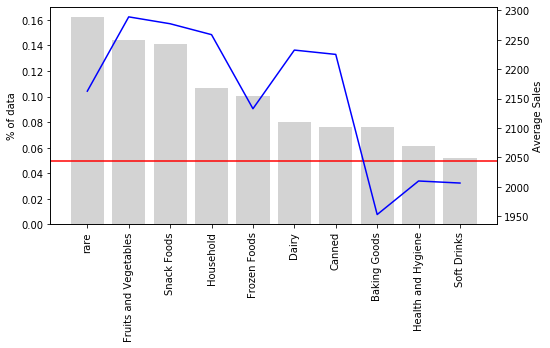

In [37]:
plot_mean(data, 'Item_Type')

#### 3. Outlet Identifier

There is a big no. of labels. Let us plot the output variable against each level.

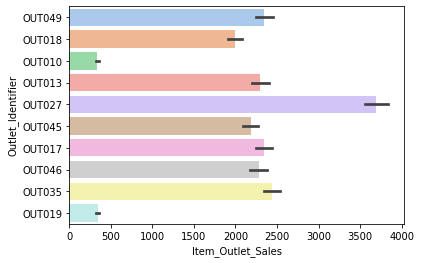

In [38]:
sns.barplot(y = 'Outlet_Identifier',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

Let us dig deep into outlet identifier.

Some of the labels can be clubbed together as they have same distribution across the target variable. Let us confirm the hypothesis through one-way ANOVA

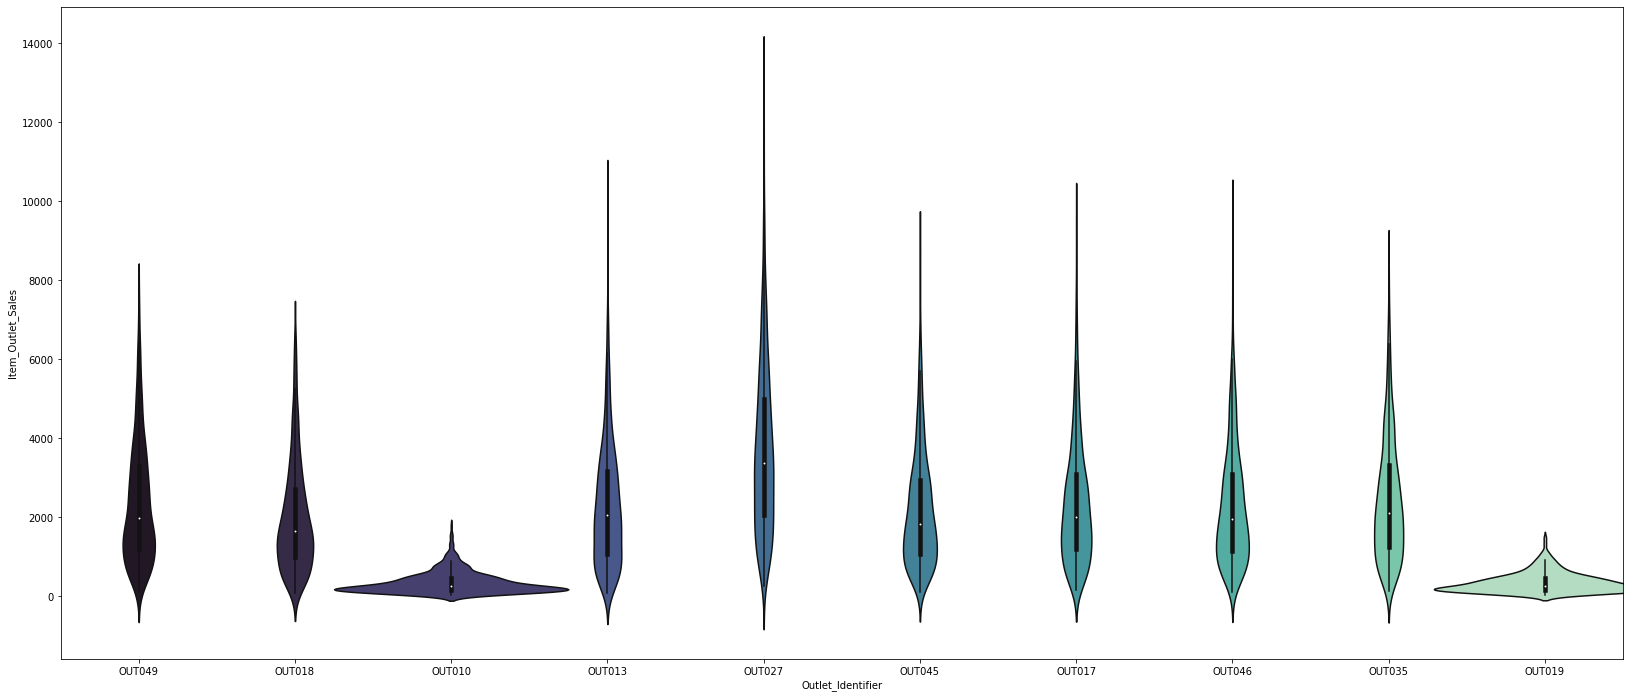

In [39]:
plt.figure(figsize= (28,12))
sns.violinplot(x= 'Outlet_Identifier', y= 'Item_Outlet_Sales', width= 1.5, data= data, palette= 'mako')

In [40]:
identifier= data['Outlet_Identifier'].unique()
combo= list(itertools.combinations(identifier, 2))
for i in combo:
    fvalue, pvalue = stats.f_oneway(data[data['Outlet_Identifier']== i[0]]['Item_Outlet_Sales'],data[data['Outlet_Identifier']== i[1]]['Item_Outlet_Sales'])
    print(f"p-value of {i[0]} and {i[1]} is {pvalue}")

p-value of OUT049 and OUT018 is 1.6237610660043112e-07
p-value of OUT049 and OUT010 is 6.83969470305172e-163
p-value of OUT049 and OUT013 is 0.4846168437306292
p-value of OUT049 and OUT027 is 1.877987516159982e-52
p-value of OUT049 and OUT045 is 0.023963611637588412
p-value of OUT049 and OUT017 is 0.9140329144118972
p-value of OUT049 and OUT046 is 0.3111714413542868
p-value of OUT049 and OUT035 is 0.20115834440551564
p-value of OUT049 and OUT019 is 2.1272163678298524e-156
p-value of OUT018 and OUT010 is 4.800336496067525e-139
p-value of OUT018 and OUT013 is 7.500690453772567e-06
p-value of OUT018 and OUT027 is 5.856140005447328e-84
p-value of OUT018 and OUT045 is 0.002846968971197406
p-value of OUT018 and OUT017 is 4.385309432249914e-07
p-value of OUT018 and OUT046 is 2.28906391365231e-05
p-value of OUT018 and OUT035 is 7.603052607618273e-11
p-value of OUT018 and OUT019 is 1.8122293078826514e-133
p-value of OUT010 and OUT013 is 1.4901491481022403e-153
p-value of OUT010 and OUT027 is 1.

In [41]:
fvalue, pvalue = stats.f_oneway(data[data['Outlet_Identifier']== 'OUT017']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT049']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT013']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT046']['Item_Outlet_Sales'],
                                
                               )



pvalue

0.7138206624905409

In [42]:
fvalue, pvalue = stats.f_oneway(data[data['Outlet_Identifier']== 'OUT010']['Item_Outlet_Sales'],
                                data[data['Outlet_Identifier']== 'OUT019']['Item_Outlet_Sales'],
                               
            
                               )

pvalue

0.9508542567870439

This confirms that there is no statistically significant difference in the target variable distribution between OUT017, OUT049, OUT013, OUT046 identifiers. So they can be combined to one label.

Similarly, OUT010 and OUT019 can be combined to one label.

In [43]:
#creating a grouping dictionary for mapping

grouping_dict = {
        k: ('Cluster0' if k in ['OUT017', 'OUT049', 'OUT013', 'OUT046']
            else k)
        for k in data['Outlet_Identifier'].unique()
        
    }
grouping_dict['OUT010']= 'Cluster1'
grouping_dict['OUT019']= 'Cluster1'
grouping_dict

{'OUT049': 'Cluster0',
 'OUT018': 'OUT018',
 'OUT010': 'Cluster1',
 'OUT013': 'Cluster0',
 'OUT027': 'OUT027',
 'OUT045': 'OUT045',
 'OUT017': 'Cluster0',
 'OUT046': 'Cluster0',
 'OUT035': 'OUT035',
 'OUT019': 'Cluster1'}

In [44]:
data['Outlet_Identifier']= data['Outlet_Identifier'].map(grouping_dict)
data['Outlet_Identifier'].unique()

array(['Cluster0', 'OUT018', 'Cluster1', 'OUT027', 'OUT045', 'OUT035'],
      dtype=object)

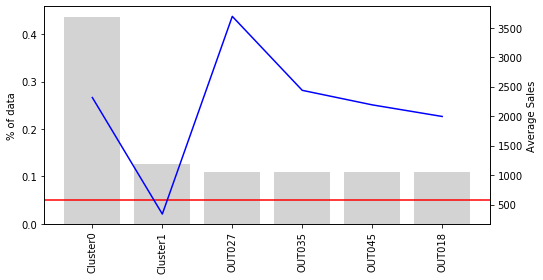

In [45]:
plot_mean(data, 'Outlet_Identifier')

## Step 3 - Feature Engineering

We can convert the establishment year to age since it will have a more linear relationship.

In [46]:
data['Outlet_Establishment_Year']= 2022-data['Outlet_Establishment_Year']

## Step 4- Imputation of missing values

In [47]:
data.isna().mean()

Item_Identifier              0.000000
Item_Weight                  0.171653
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282764
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Outlet_Sales            0.000000
dtype: float64

**Outlet size** has a significant portion of missing data. Let us fill an arbitrary value and see the distribution of outcome variable over this feature.

Since there is a significant number of missing values, imputing them with mode may distort the underlying distribution.

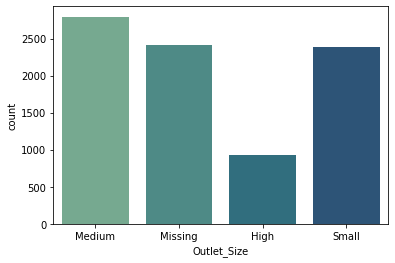

In [48]:
data['Outlet_Size'].fillna('Missing', inplace= True)
sns.countplot(x='Outlet_Size', data= data , palette='crest')
plt.show()


Now let us plot the distribution of output variable against different levels of Outlet_Size

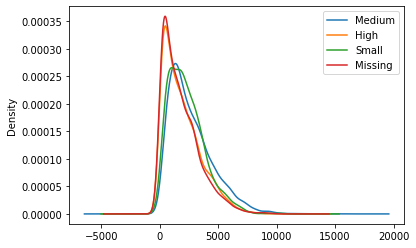

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)

data[data['Outlet_Size']== 'Medium']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
data[data['Outlet_Size']== 'Small']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
data[data['Outlet_Size']== 'High']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
data[data['Outlet_Size']== 'Missing']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)

lines, labels = ax.get_legend_handles_labels()
labels= ['Medium', 'High', 'Small', 'Missing']
ax.legend(lines, labels, loc='best')

The distribution of missing label looks very similar to small. 

Maybe the small outlets do not maintain this information in the transaction level data.

In [50]:
fvalue, pvalue = stats.f_oneway(data[data['Outlet_Size']== 'Small']['Item_Outlet_Sales'],
                                data[data['Outlet_Size']== 'Missing']['Item_Outlet_Sales']
                                
                               )

pvalue

0.048361369714643075

There maybe a statistically significant difference between the distribution within the small and missing labels as suggested by the p-value. So let us retain the missing value indicator.

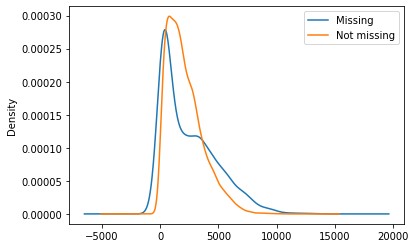

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
data[data['Item_Weight'].isna()]['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
data[~data['Item_Weight'].isna()]['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
lines, labels = ax.get_legend_handles_labels()
labels= ['Missing', 'Not missing']
ax.legend(lines, labels, loc='best')
plt.show()

There is a significant portion of data that is missing (~19%). For such thresholds, imputing with median/mean may distort the variance and covariance with other variables of the dataset.

Let us use KNN imputer. For that, we first need to standardize the dataset, since KNN is a distance based method.
We cannot use min max scaler as there are big outliers in the dataset. Let us use standard scaler.

In [52]:
imputer = KNNImputer(
    n_neighbors=5,
    weights='distance', 
    metric='nan_euclidean',
    add_indicator=False,
)

In [53]:
scaler= StandardScaler()
data[num_col]= scaler.fit_transform(data[num_col])


data['Item_Weight']= imputer.fit_transform(data[num_col])

In [54]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Food,-0.766217,Low Fat,-0.970732,Dairy,1.747454,Cluster0,-0.139541,Medium,Tier 1,Supermarket Type1,3735.1380
1,Drinks,-1.494175,Regular,-0.908111,Soft Drinks,-1.489023,OUT018,-1.334103,Medium,Tier 3,Supermarket Type2,443.4228
2,Food,0.999834,Low Fat,-0.956917,rare,0.010040,Cluster0,-0.139541,Medium,Tier 1,Supermarket Type1,2097.2700
3,Food,1.365966,Regular,-1.281758,Fruits and Vegetables,0.660050,Cluster1,-0.020085,Missing,Tier 3,Grocery Store,732.3800
4,Non Consumable,-0.845905,Not Applicable,-1.281758,Household,-1.399220,Cluster0,1.293934,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,Food,-1.290648,Low Fat,-0.181193,Snack Foods,1.180783,Cluster0,1.293934,High,Tier 3,Supermarket Type1,2778.3834
8519,Food,-0.964360,Regular,-0.371154,Baking Goods,-0.527301,OUT045,-0.497909,Missing,Tier 2,Supermarket Type1,549.2850
8520,Non Consumable,-0.486234,Not Applicable,-0.599784,Health and Hygiene,-0.897208,OUT035,-0.736822,Small,Tier 2,Supermarket Type1,1193.1136
8521,Food,-1.216345,Regular,1.532880,Snack Foods,-0.607977,OUT018,-1.334103,Medium,Tier 3,Supermarket Type2,1845.5976


In [55]:
data.isna().sum() #all variables imputed

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Step 5- Plotting against Output variable

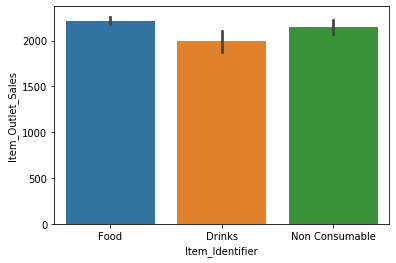

In [56]:
#The average sales across different item types is quite even

sns.barplot(x='Item_Identifier', y='Item_Outlet_Sales', data=data)
plt.show()

In [57]:
fvalue, pvalue = stats.f_oneway(data[data['Item_Identifier']== 'Food']['Item_Outlet_Sales'],
                                data[data['Item_Identifier']== 'Drinks']['Item_Outlet_Sales'],
                                data[data['Item_Identifier']== 'Non Consumable']['Item_Outlet_Sales']
                                
                               )



pvalue
#This column may be meaningful in prediction.

0.0018844050713309338

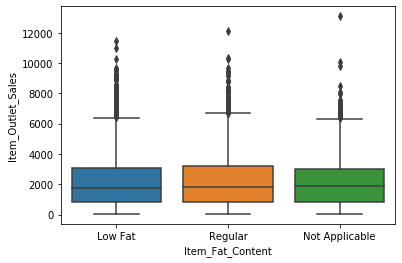

In [58]:
sns.boxplot(x= 'Item_Fat_Content', y= 'Item_Outlet_Sales', data= data)

In [59]:
fvalue, pvalue = stats.f_oneway(data[data['Item_Fat_Content']== 'Low Fat']['Item_Outlet_Sales'],
                                data[data['Item_Fat_Content']== 'Regular']['Item_Outlet_Sales'],
                                data[data['Item_Fat_Content']== 'Not Applicable']['Item_Outlet_Sales']
                                
                                
                               )
pvalue

0.2060216950157096

Text(0.5, 1.0, 'Outlet Sales by Fat Content')

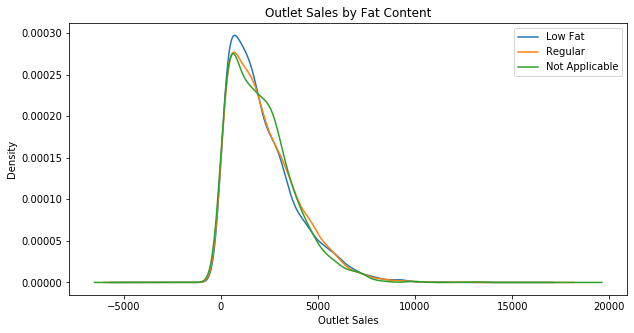

In [60]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(111)

data[data['Item_Fat_Content']== 'Low Fat']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
data[data['Item_Fat_Content']== 'Regular']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)
data[data['Item_Fat_Content']== 'Not Applicable']['Item_Outlet_Sales'].plot(kind= 'kde', ax=ax)

lines, labels = ax.get_legend_handles_labels()
labels= ['Low Fat', 'Regular', 'Not Applicable']
ax.legend(lines, labels, loc='best')
ax.set_xlabel('Outlet Sales')
ax.set_title('Outlet Sales by Fat Content')

In [61]:
data.drop('Item_Fat_Content', axis=1, inplace= True)
data

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Food,-0.766217,-0.970732,Dairy,1.747454,Cluster0,-0.139541,Medium,Tier 1,Supermarket Type1,3735.1380
1,Drinks,-1.494175,-0.908111,Soft Drinks,-1.489023,OUT018,-1.334103,Medium,Tier 3,Supermarket Type2,443.4228
2,Food,0.999834,-0.956917,rare,0.010040,Cluster0,-0.139541,Medium,Tier 1,Supermarket Type1,2097.2700
3,Food,1.365966,-1.281758,Fruits and Vegetables,0.660050,Cluster1,-0.020085,Missing,Tier 3,Grocery Store,732.3800
4,Non Consumable,-0.845905,-1.281758,Household,-1.399220,Cluster0,1.293934,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
8518,Food,-1.290648,-0.181193,Snack Foods,1.180783,Cluster0,1.293934,High,Tier 3,Supermarket Type1,2778.3834
8519,Food,-0.964360,-0.371154,Baking Goods,-0.527301,OUT045,-0.497909,Missing,Tier 2,Supermarket Type1,549.2850
8520,Non Consumable,-0.486234,-0.599784,Health and Hygiene,-0.897208,OUT035,-0.736822,Small,Tier 2,Supermarket Type1,1193.1136
8521,Food,-1.216345,1.532880,Snack Foods,-0.607977,OUT018,-1.334103,Medium,Tier 3,Supermarket Type2,1845.5976


It looks like the distribution of Item outlet sales across the item fat content looks near identical across all three levels.
So this column is not necessarily adding any information.
As feature selection, we can explore removing this variable.

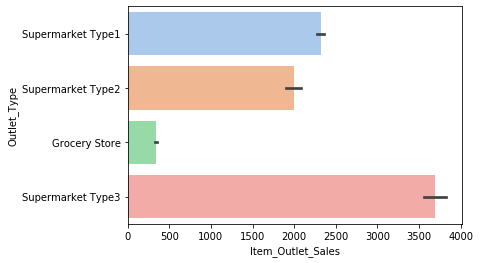

In [62]:
sns.barplot(y = 'Outlet_Type',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

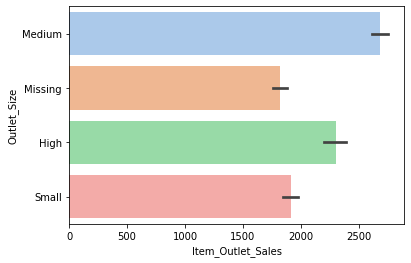

In [63]:
sns.barplot(y = 'Outlet_Size',x = 'Item_Outlet_Sales',data=data,palette='pastel')
plt.show()

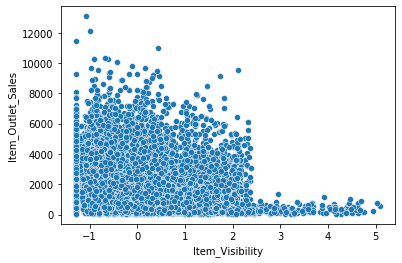

In [64]:
sns.scatterplot(x = 'Item_Visibility',y = 'Item_Outlet_Sales',data=data)
plt.show()

Till a visibility level of 0.2, the sales are not affected strongly by visibility. Beyond a visibility of 0.2, the sales are quite low.

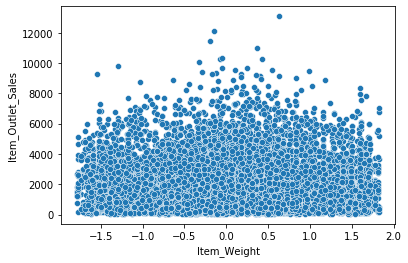

In [65]:
sns.scatterplot(x = 'Item_Weight',y = 'Item_Outlet_Sales',data=data)
plt.show()

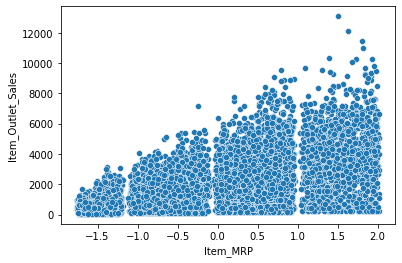

In [66]:
sns.scatterplot(x = 'Item_MRP',y = 'Item_Outlet_Sales',data=data)
plt.show()

### Step 6- Creating dummy variables for categorical variable encoding

In [67]:
cat_col.remove('Item_Fat_Content')
cat_col

['Item_Identifier',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [68]:
identifier_dummies= pd.get_dummies(data.Item_Identifier)
data= pd.concat([data, identifier_dummies], axis=1)

In [69]:
data.drop('Item_Identifier', axis=1, inplace= True)
data

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Drinks,Food,Non Consumable
0,-0.766217,-0.970732,Dairy,1.747454,Cluster0,-0.139541,Medium,Tier 1,Supermarket Type1,3735.1380,0,1,0
1,-1.494175,-0.908111,Soft Drinks,-1.489023,OUT018,-1.334103,Medium,Tier 3,Supermarket Type2,443.4228,1,0,0
2,0.999834,-0.956917,rare,0.010040,Cluster0,-0.139541,Medium,Tier 1,Supermarket Type1,2097.2700,0,1,0
3,1.365966,-1.281758,Fruits and Vegetables,0.660050,Cluster1,-0.020085,Missing,Tier 3,Grocery Store,732.3800,0,1,0
4,-0.845905,-1.281758,Household,-1.399220,Cluster0,1.293934,High,Tier 3,Supermarket Type1,994.7052,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.290648,-0.181193,Snack Foods,1.180783,Cluster0,1.293934,High,Tier 3,Supermarket Type1,2778.3834,0,1,0
8519,-0.964360,-0.371154,Baking Goods,-0.527301,OUT045,-0.497909,Missing,Tier 2,Supermarket Type1,549.2850,0,1,0
8520,-0.486234,-0.599784,Health and Hygiene,-0.897208,OUT035,-0.736822,Small,Tier 2,Supermarket Type1,1193.1136,0,0,1
8521,-1.216345,1.532880,Snack Foods,-0.607977,OUT018,-1.334103,Medium,Tier 3,Supermarket Type2,1845.5976,0,1,0


In [70]:
cat_col.remove('Item_Identifier')
cat_col

['Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [71]:
for i in cat_col:
    df_dummies= pd.get_dummies(data[i])
    data= pd.concat([data, df_dummies], axis=1)
    data.drop(i, axis=1, inplace= True)

In [72]:
data

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Drinks,Food,Non Consumable,Baking Goods,Canned,...,Medium,Missing,Small,Tier 1,Tier 2,Tier 3,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,-0.766217,-0.970732,1.747454,-0.139541,3735.1380,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,-1.494175,-0.908111,-1.489023,-1.334103,443.4228,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,0.999834,-0.956917,0.010040,-0.139541,2097.2700,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3,1.365966,-1.281758,0.660050,-0.020085,732.3800,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,-0.845905,-1.281758,-1.399220,1.293934,994.7052,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.290648,-0.181193,1.180783,1.293934,2778.3834,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8519,-0.964360,-0.371154,-0.527301,-0.497909,549.2850,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
8520,-0.486234,-0.599784,-0.897208,-0.736822,1193.1136,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
8521,-1.216345,1.532880,-0.607977,-1.334103,1845.5976,0,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [73]:
X= data.drop('Item_Outlet_Sales', axis=1)
X

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Drinks,Food,Non Consumable,Baking Goods,Canned,Dairy,...,Medium,Missing,Small,Tier 1,Tier 2,Tier 3,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,-0.766217,-0.970732,1.747454,-0.139541,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,0,0
1,-1.494175,-0.908111,-1.489023,-1.334103,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,0.999834,-0.956917,0.010040,-0.139541,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3,1.365966,-1.281758,0.660050,-0.020085,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,-0.845905,-1.281758,-1.399220,1.293934,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.290648,-0.181193,1.180783,1.293934,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8519,-0.964360,-0.371154,-0.527301,-0.497909,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
8520,-0.486234,-0.599784,-0.897208,-0.736822,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
8521,-1.216345,1.532880,-0.607977,-1.334103,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


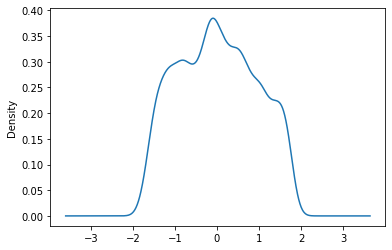

In [74]:
X['Item_Weight'].plot(kind='kde')

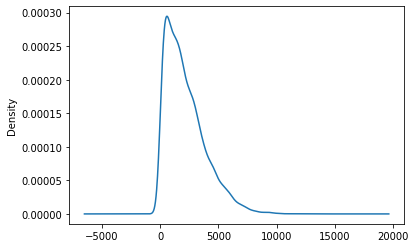

In [75]:
y= data['Item_Outlet_Sales']
y.plot(kind= 'kde')

### Step 7- Testing models

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
lr= LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [78]:
y_pred= lr.predict(X_train)
lr_mse= mean_squared_error(y_train, y_pred)
lr_rmse= np.sqrt(lr_mse)
lr_rmse

1141.8891000846936

In [79]:
r2_score(y_train, y_pred)

0.5591992654252191

In [80]:
tree_reg= DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
y_pred= tree_reg.predict(X_train)
tree_mse= mean_squared_error(y_train, y_pred)
tree_rmse= np.sqrt(tree_mse)
tree_rmse


0.0

Decision tree is clearly overfitting so let us use a random forest regressor with parameters tuned with grid search.

In [81]:
param_grid= [{'n_estimators': [100,250], 'max_features': [12,18,20], 'min_samples_leaf': [4,6,8], 'max_depth': [6,8,10,12]}]

In [83]:
rf= RandomForestRegressor()

grid_search= GridSearchCV(rf, param_grid, cv=5, return_train_score= True )

In [ ]:
#grid_search.fit(X_train, y_train)
#grid_search.best_params_


#final_model= grid_search.best_estimator_
#final_pred= final_model.predict(X_test)
#r2_score(y_test, final_pred)

In [84]:
#best model

rf= RandomForestRegressor(n_estimators =500,
 max_features= 21,
 min_samples_leaf= 5,
max_depth= 6)

rf.fit(X_train, y_train)
train_pred= rf.predict(X_train)
final_pred= rf.predict(X_test)
r2_score(y_test, final_pred), r2_score(y_train, train_pred)




(0.619760547416573, 0.6183935543373751)

### Step 8- Putting all feature engineering together- Custom transformers

Steps to be part of the pipeline

1. Clustering of item identifier, item type & Outlet identifier and dropping of item fat content-> Categorical pipeline
2. Feature engineering of outlet establishment year-> Numerical pipeline
3. KNN Imputation of Numerical feature and Missing value with Small for Outlet type in categorical feature. For the rest, just impute with median.

4. Standard Scalar-> For both
5. One hot encoding-> Categorical feature

In [135]:
url= "https://raw.githubusercontent.com/nithinpradeep38/datasets/main/Train.csv"
data= pd.read_csv(url)
cat_col= [col for col in data.columns if data[col].dtype== 'object']
num_col= [col for col in data.columns if data[col].dtype!= 'object']
num_col.remove('Item_Outlet_Sales')
num_col, cat_col

(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'],
 ['Item_Identifier',
  'Item_Fat_Content',
  'Item_Type',
  'Outlet_Identifier',
  'Outlet_Size',
  'Outlet_Location_Type',
  'Outlet_Type'])

In [136]:

class FeatureGenerator(BaseEstimator, TransformerMixin):


    def __init__(self,  Outlet_Establishment_Year_id= 3):
        self.Outlet_Establishment_Year_id= Outlet_Establishment_Year_id
        
    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y= None):
        X= pd.DataFrame(X, columns= ['Item_Weight', 
                                         'Item_Visibility', 
                                         'Item_MRP', 
                                         'Outlet_Establishment_Year'])
            
        X.iloc[:,self.Outlet_Establishment_Year_id]= 2022- X.iloc[:,self.Outlet_Establishment_Year_id]
                            
        return X
                

In [137]:
class CategoryGenerator(BaseEstimator, TransformerMixin):


    def __init__(self,  
                 Item_Identifier_id= 0, 
                 Item_Fat_Content_id=1, 
                 Item_Type_id= 2, 
                 Outlet_Identifier_id=3
                ):
        self.Item_Identifier_id= Item_Identifier_id
        self.Item_Fat_Content_id= Item_Fat_Content_id
        self.Item_Type_id= Item_Type_id
        self.Outlet_Identifier_id= Outlet_Identifier_id
        
        

    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y= None):
            X= pd.DataFrame(X, columns= ['Item_Identifier',
                                         'Item_Fat_Content',
                                         'Item_Type',
                                         'Outlet_Identifier',
                                         'Outlet_Size',
                                         'Outlet_Location_Type',
                                         'Outlet_Type'])
            
            X.iloc[:,self.Item_Identifier_id]= X.iloc[:,self.Item_Identifier_id].map(
                {"Low Fat": 'Low Fat', "LF": "Low Fat", 'low fat': "Low Fat", "Regular": "Regular"})
            
            X.iloc[:, self.Item_Fat_Content_id]= X.iloc[:, self.Item_Fat_Content_id].apply(lambda x: x[0:2]).map(
                {"FD": "Food", "DR": "Drink", "NC": "Non_consumable"})
            
            item_grouping_dict= {'Dairy': 'Dairy',
                             'Soft Drinks': 'Soft Drinks',
                             'Meat': 'rare',
                             'Fruits and Vegetables': 'Fruits and Vegetables',
                             'Household': 'Household',
                             'Baking Goods': 'Baking Goods',
                             'Snack Foods': 'Snack Foods',
                             'Frozen Foods': 'Frozen Foods',
                             'Breakfast': 'rare',
                             'Health and Hygiene': 'Health and Hygiene',
                             'Hard Drinks': 'rare',
                             'Canned': 'Canned',
                             'Breads': 'rare',
                             'Starchy Foods': 'rare',
                             'Others': 'rare',
                             'Seafood': 'rare'}
            
            X.iloc[:, self.Item_Type_id]= X.iloc[:, self.Item_Type_id].map(item_grouping_dict)
            
            Outlet_grouping_dict= {  'OUT049': 'Cluster0',
                                     'OUT018': 'OUT018',
                                     'OUT010': 'Cluster1',
                                     'OUT013': 'Cluster0',
                                     'OUT027': 'OUT027',
                                     'OUT045': 'OUT045',
                                     'OUT017': 'Cluster0',
                                     'OUT046': 'Cluster0',
                                     'OUT035': 'OUT035',
                                     'OUT019': 'Cluster1'
                                  }
            X.iloc[:, self.Outlet_Identifier_id]= X.iloc[:, self.Outlet_Identifier_id].map(Outlet_grouping_dict)
            
            return X
            
            

In [138]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy="median")),
                ('feature_generator', FeatureGenerator()),
                ('scaler', StandardScaler())
            ]
            )

cat_pipeline = Pipeline(steps=[
                ('impute', SimpleImputer(strategy="most_frequent")),
                 ( 'classgenerator', CategoryGenerator()),
                 ('one_hot_encoder', OneHotEncoder()),
                 ('scaler', StandardScaler(with_mean=False))
            ]
            )

In [139]:
preprocessing = ColumnTransformer([
                ('num_pipeline', num_pipeline, num_col),
                ('cat_pipeline', cat_pipeline, cat_col)
            ])

In [140]:
a= preprocessing.fit_transform(data)
type(a)

numpy.ndarray

**We have conducted all the feature engineering discussed into a custom transformer which we can use to apply fit onto training data and then transform the testing data.**


### **This concludes the EDA**

### Miscellaneous work- Please ignore

In [328]:
#xgb= XGBRegressor()
#xgb.fit(X_train, y_train)
#train_pred= xgb.predict(X_train)
#final_pred= xgb.predict(X_test)
#r2_score(y_test, final_pred), r2_score(y_train, train_pred)

#param_grid= [{'n_estimators':[500,750,1000], 'max_depth': [4,5,6], 'eta': [0.01, 0.1, 0.3]}]
#grid_search= GridSearchCV(xgb, param_grid, cv=5, scoring= 'neg_mean_squared_error', return_train_score= True )
#grid_search.fit(X_train, y_train)

#final_model= grid_search.best_estimator_
#final_pred= final_model.predict(X_test)
#r2_score(y_test, final_pred)

#y_pred= final_model.predict(X_train)
#r2_score(y_train, y_pred)

(0.5375342246590131, 0.8510193756691949)

In [159]:
"""
CatBoostRegressor
model_cb = CatBoostRegressor()
param_grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

grid_search= GridSearchCV(model_cb, param_grid, cv=5, scoring= 'neg_mean_squared_error', return_train_score= True )
grid_search.fit(X_train, y_train)
"""


In [141]:
#grid_search.best_params_

In [142]:
"""
final_model= grid_search.best_estimator_
final_pred= final_model.predict(X_test)
y_pred= final_model.predict(X_train)
r2_score(y_train, y_pred), r2_score(y_test, final_pred)
"""


'\nfinal_model= grid_search.best_estimator_\nfinal_pred= final_model.predict(X_test)\ny_pred= final_model.predict(X_train)\nr2_score(y_train, y_pred), r2_score(y_test, final_pred)\n'

In [143]:
"""
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
                'n_estimators': [10, 20, 40, 50, 100, 150, 200, 500],
                'max_features': [2,4,6,8,10,14,18,22],
                'max_depth': [5, 7, 9, 11, 15,18],
                'bootstrap': [True, False],
                'min_samples_leaf': [4,8,12,16]
                }
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

"""


"\nfrom sklearn.model_selection import RandomizedSearchCV\nrandom_grid = {\n                'n_estimators': [10, 20, 40, 50, 100, 150, 200, 500],\n                'max_features': [2,4,6,8,10,14,18,22],\n                'max_depth': [5, 7, 9, 11, 15,18],\n                'bootstrap': [True, False],\n                'min_samples_leaf': [4,8,12,16]\n                }\nrf = RandomForestRegressor()\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\nrf_random.fit(X_train, y_train)\nrf_random.best_params_\n\n"

In [144]:
"""
final_pred= rf_random.predict(X_test)
y_pred= rf_random.predict(X_train)
r2_score(y_train, y_pred),r2_score(y_test, final_pred)
"""


'\nfinal_pred= rf_random.predict(X_test)\ny_pred= rf_random.predict(X_train)\nr2_score(y_train, y_pred),r2_score(y_test, final_pred)\n'

In [ ]:
"""
Testing transformations

y_train_log= np.log1p(y_train)

y_test_log= np.log1p(y_test)

from scipy.stats import boxcox
from scipy.special import inv_boxcox
y_train_boxcox,fitted_lambda= boxcox(y_train,lmbda=None)
boxcox(y_train,lmbda=None)


y_train_boxcox
y_test_boxcox= boxcox(y_test, lmbda= 0.3467646810593698)
y_test_boxcox

inv_boxcox(y_test_boxcox,0.3467646810593698)

"""
